'NimbusRoman-Regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


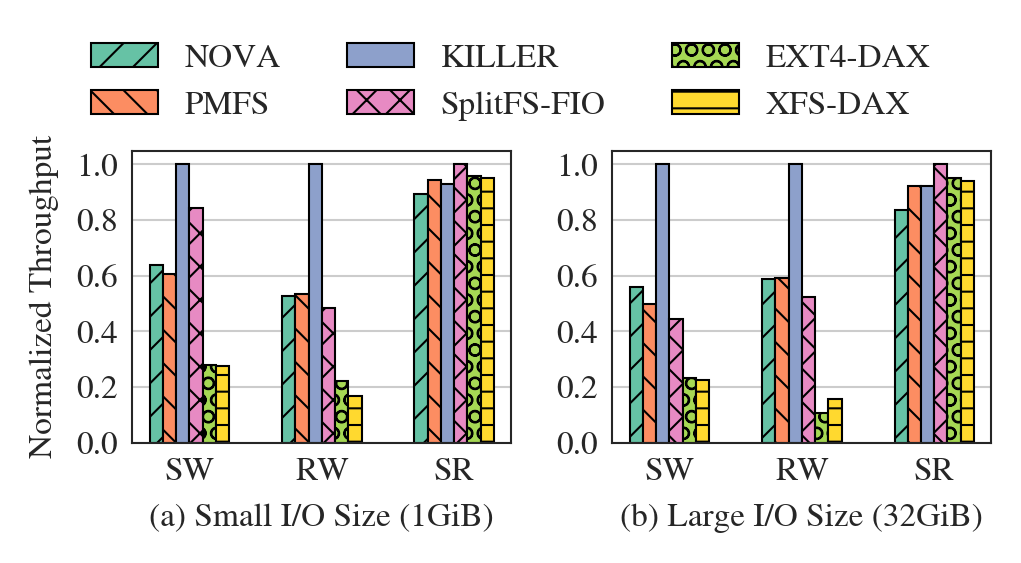

In [6]:
# ipython -c "%run plot.ipynb"

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import style
import pandas as pd
import matplotlib.gridspec as gridspec


# Paper specific settings
STANDARD_WIDTH = 17.8
SINGLE_COL_WIDTH = STANDARD_WIDTH / 2
DOUBLE_COL_WIDTH = STANDARD_WIDTH
def cm_to_inch(value):
    return value/2.54
    
# matplotlib style settings
matplotlib.rcParams['text.usetex'] = False
style.use('seaborn-white')
plt.rcParams["axes.grid"] = True
plt.rcParams["axes.grid.axis"] = "y"
plt.rcParams["grid.linewidth"] = 0.5
plt.rcParams['hatch.linewidth'] = 0.5
plt.rcParams["font.family"] = "Nimbus Roman"
pd.options.display.max_columns = None
pd.options.display.max_rows = None


# Data Preprocessing
# with open("./avg-test-result-in-paper", "r") as f:
with open("./performance-comparison-table-large", "r") as f:
    df_io_large = pd.read_csv(f, delim_whitespace=True, index_col=None, engine='python')
with open("./performance-comparison-table-small", "r") as f:
    df_io_small = pd.read_csv(f, delim_whitespace=True, index_col=None, engine='python')

df_io_large.drop(df_io_large[df_io_large['file_system'] == "PMM"].index, inplace=True)
df_io_small.drop(df_io_small[df_io_small['file_system'] == "PMM"].index, inplace=True)

# Plotting Settings
fig = plt.figure(dpi = 300, figsize = (cm_to_inch(SINGLE_COL_WIDTH), cm_to_inch(4)))
bar_width = 0.1
subfig_titles = ["(a) Small I/O Size (1GiB)", "(b) Large I/O Size (32GiB)"]
patterns = ['///', '\\\\\\', '', 'XXX', 'OOO', '---', '+++']
# Reference: https://designbro.com/blog/inspiration/color-combinations/
colors = ["#2b2d42", "#8d99ae", "#edf2f4", "#ef233c", "#ef233c", "#ef233c", "#ef233c", "#ef233c",]

dfs = [df_io_small, df_io_large]

for df_idx, df in enumerate(dfs):
    plt.subplot(1, 2, df_idx + 1)
    fss = df['file_system'].drop_duplicates().reset_index().drop(columns=['index'])['file_system']
    ops = ["seq-write", "rnd-write", "seq-read"]
    tot = len(fss) * bar_width
    x = list(range(1, len(ops) + 1))

    for op in ops:
        value = df[df['ops'] == op]['bandwidth(MiB/s)'] / df[df['ops'] == op]['bandwidth(MiB/s)'].max()
        df.loc[df['ops'] == op, 'bandwidth(MiB/s)'] = value
    
    for idx, fs in enumerate(fss):
        points = []
        for pivot in x:
            point = pivot - tot / 2 + bar_width / 2 + idx * bar_width
            points.append(point)
        bws = []
        for op in ops:
            bws.append(df[(df['file_system'] == fs) & (df['ops'] == op)]['bandwidth(MiB/s)'].iloc[0])
        if fs == "PMM":
            plt.axhline(1, color=colors[idx], linestyle='--', linewidth=1)
        else:
            plt.bar(points, bws, width=bar_width, hatch=patterns[idx], edgecolor='black', color=plt.get_cmap('Set2')(idx), linewidth=0.5)
    
    # Draw title
    plt.xticks(x, labels=["SW", "RW", "SR"], fontsize=8)
    plt.yticks([0, 0.2, 0.4, 0.6, 0.8, 1], fontsize=8)
    plt.xlabel(subfig_titles[df_idx], fontsize=8) 
    if (df_idx == 0):
        plt.ylabel('Normalized Throughput', fontsize=8)

    ax = fig.gca()
    lw = 0.5
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(lw)
        
# legend_labels = ["PMM"]
legend_labels = fss
# legend_labels.extend(fss[:-1]) 
fig.legend(legend_labels, loc='center', bbox_to_anchor=(0.5, 1.05), ncol=3, fontsize=8, frameon=False)
plt.tight_layout()
plt.savefig("./FIG-IO.pdf", bbox_inches='tight', pad_inches=0)
